The web scraping isn't fully done, but at least you got a piece of it.


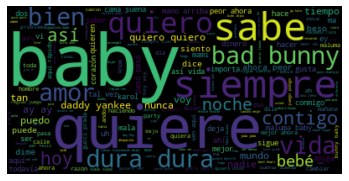

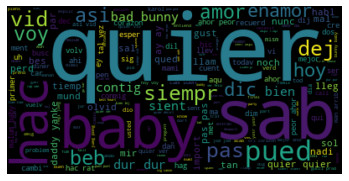

<Figure size 432x288 with 0 Axes>

In [2]:
import scraper, extractor, cleaner, transformer, analyzer, loader
import pandas as pd
import matplotlib.pyplot as plt


def scrape():
    df = scraper.scrape_reggaeton_lyrics()
    return df

    
def clean(df):
    # Limpiar las etiquetas de html
    df['Lyrics'] = df['Lyrics'].apply(cleaner.clean_html_tags)
    # Convertir la lista de listas en una lista de strings (donde cada string es un verso)
    df['Lyrics'] = df['Lyrics'].apply(cleaner.flatten_list)
    # Eliminar el '' que se me genera en todas las canciones después de la primera estrofa
    df['Lyrics'] = df['Lyrics'].apply(cleaner.remove_linebreak)
    loader.load_json(df, "Reggaeton_lyrics.json")
    return df
    
    
def extract():
    df = extractor.extract_json('Reggaeton_lyrics.json')
    return df


def transform(df):
    import statistics
    # Crear una columna con la traducción de las canciones de español a inglés
    df['Translation'] = df['Lyrics'].apply(transformer.translate_list)
    
    # Crear una columna con el cálculo de sentimiento de las canciones en inglés.
    df['Sentiment'] = df['Translation'].apply(transformer.analyze_sentiment)
    
    # Crear una columna con el cálculo de la media del sentimiento por canción.
    try:
        df['Sent_mean'] = df['Sentiment'].apply(statistics.mean)
    except:
        pass
    
    # Crear una columna con todas las palabras de las canciones sin stopwords.
    df['No_stopwords'] = df['Lyrics'].apply(transformer.remove_stopwords)
    return df


def analyze(df):
    # Imprimir la nube de palabras relevantes
    relevant_words = pd.Series(df['No_stopwords'].sum())
    analyzer.print_wordcloud(relevant_words)
    plt.savefig('wordcloud.png')
    
    # Imprimir la nube de lexemas de las palabras relevantes
    stemmed_words = analyzer.get_stemming(relevant_words)
    analyzer.print_wordcloud(stemmed_words)
    plt.savefig('stemmed_wordcloud.png')

    
def load(df):
    loader.load_csv(df, "Reggaeton_lyrics.csv")


    

def main():
    # Verificar si ya hay un json en el directorio, resultado de un scraping anterior.
    # Si no existe, hago scraping.
    # Si existe, uso el json. Con esto evito tener que hacer scraping cada vez que ejecuto el pipeline.
    import os
    exists = os.path.isfile("Reggaeton_lyrics.json")
    if not exists:
        df = scrape()
        clean_df = clean(df)
    else:
        print("The file 'Reggaeton_lyrics.json' already exists, so let's work on it.")
        clean_df = extract()
    
    transformed_df = transform(clean_df)
    analyze(transformed_df)
    load(transformed_df)

    
if __name__ == "__main__":
    main()